# AE on proteins in SA representation - protein level

In [1]:
import glob
import os
from collections import Counter
import string
from keras import Input
from keras.layers import Dense, Lambda, Conv1D
import keras.backend as K
from keras.models import Model
from keras.objectives import binary_crossentropy, mse
import os
import random
import numpy as np
from keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from tempfile import TemporaryFile

Using TensorFlow backend.


### Configurations

In [2]:
families = ["fam_1", "fam_2", "fam_3", "fam_4", "fam_5", "fam_6", "fam_7", "fam_8", "fam_9"]
ds_path = "Dataset/families"
ds_serialized_path = "/Volumes/SSD_Carmina/dizy/data_serialized_protein"
family_paths = {}
for f in families:
    family_paths[f]= os.path.join(ds_path, f)

In [3]:
letters_di=dict(zip(string.ascii_letters,[ord(c)%32 -1 for c in string.ascii_letters]))

In [4]:
padding = True
num_classes = 25
categorical = True
normalize = False
max_length = 668
flatten = True

In [5]:
lengths = {}
for f in families:
    proteins = glob.glob(os.path.join(family_paths[f], "*.out"))
    print("Proteins for family %s" %f)
    for p in proteins:
        print(p)
    lengths[f] = len(p)
total = sum([lengths[f] for f in families])

Proteins for family fam_1
Dataset/families/fam_1/2EBN.lf_str.out
Dataset/families/fam_1/1JFX.lf_str.out
Dataset/families/fam_1/1ITX.lf_str.out
Dataset/families/fam_1/1NAR.lf_str.out
Dataset/families/fam_1/1KFW.lf_str.out
Dataset/families/fam_1/1B1Y.lf_str.out
Dataset/families/fam_1/1VFF.lf_str.out
Dataset/families/fam_1/1EDG.lf_str.out
Dataset/families/fam_1/1CNV.lf_str.out
Proteins for family fam_2
Dataset/families/fam_2/1HLB.lf_str.out
Dataset/families/fam_2/2LHB.lf_str.out
Dataset/families/fam_2/1DLW.lf_str.out
Dataset/families/fam_2/1ITH.lf_str.out
Dataset/families/fam_2/1ECA.lf_str.out
Dataset/families/fam_2/1ASH.lf_str.out
Dataset/families/fam_2/1MBA.lf_str.out
Dataset/families/fam_2/2HBG.lf_str.out
Proteins for family fam_3
Dataset/families/fam_3/2SAS.lf_str.out
Dataset/families/fam_3/1OMR.lf_str.out
Dataset/families/fam_3/1SRA.lf_str.out
Dataset/families/fam_3/1CB1.lf_str.out
Dataset/families/fam_3/1IQ3.lf_str.out
Dataset/families/fam_3/1UHN.lf_str.out
Proteins for family fam_4

In [6]:
def read_set_for_family(f, set_type):
    ds_path = os.path.join(ds_serialized_path, f, set_type)
    files = glob.glob(os.path.join(ds_path, "*.npy"))
    new = np.load(files[0])
    for f in files[1:]:
        conf_f = np.load(f)
        new = np.concatenate([new,conf_f])
        del conf_f
    return new

### Build the autoencoder

In [8]:
batch_size = 64
intermediate_dim = 20
epochs = 25

In [23]:
def create_checkpoints(f):
    checkpoints_path = os.path.join("models_proteins_exp2", f)
    tensorboard_path = os.path.join("logs", f)
    cp_cb = ModelCheckpoint(filepath=os.path.join(checkpoints_path, "model_protein_level_" + f + ".hdf5"), monitor='val_loss',
                            save_best_only=True)
    tb_cb = TensorBoard(log_dir=tensorboard_path)
    return [cp_cb, tb_cb]

In [9]:
#autoencoder
def get_ae():
    if categorical:
        if not flatten:
            model_input = Input(shape=(None,num_classes))
        else:
            model_input = Input(shape=(max_length*num_classes,))
    else:
        model_input = Input(shape=(max_length,))
    #x=Conv1D(intermediate_dim, activation='sigmoid', kernel_size=3, padding='same', dilation_rate=1)(model_input)
    #encoded=Conv1D(intermediate_dim, activation='sigmoid', kernel_size=3, padding='same', dilation_rate=1, name="encoded")(x)
    #x=Conv1D(num_classes, activation='sigmoid', kernel_size=3, padding='same', dilation_rate=1)(encoded)
    encoded= Dense(intermediate_dim, activation='sigmoid')(model_input)
    if categorical:
        if not flatten:
            x = Dense(num_classes, activation='sigmoid')(encoded)
        else:
            x = Dense(max_length*num_classes, activation='sigmoid')(encoded)
    else:
        x = Dense(max_length, activation='sigmoid')(encoded)
    ae=Model(inputs=model_input, outputs=[x])
    opt=RMSprop(lr=0.01)
    ae.compile(optimizer=opt, loss='binary_crossentropy')
    ae.summary()
    return ae

### Train the autoencoder for specific classes

In [ ]:
for f in families:
    print("Training for family %s" %f)
    train = read_set_for_family(f,"train")
    test = read_set_for_family(f,"val")
    print("train: " + repr(train.shape))
    print("test" + repr(test.shape))
    ae = get_ae()
    ae.fit(train, train,
           shuffle=True,
           epochs=epochs,
           batch_size=batch_size,
           validation_data=(test, test),
           callbacks=create_checkpoints(f),
           verbose=1)

### Evaluate models

In [11]:
models = {"fam_1": "models_proteins_exp1/fam_1/model_protein_level_fam_1.hdf5",
          "fam_2": "models_proteins_exp1/fam_2/model_protein_level_fam_2.hdf5",
          "fam_3": "models_proteins_exp1/fam_3/model_protein_level_fam_3.hdf5",
          "fam_4": "models_proteins_exp1/fam_4/model_protein_level_fam_4.hdf5",
          "fam_5": "models_proteins_exp1/fam_5/model_protein_level_fam_5.hdf5",
          "fam_6": "models_proteins_exp1/fam_6/model_protein_level_fam_6.hdf5",
          "fam_7": "models_proteins_exp1/fam_7/model_protein_level_fam_7.hdf5",
          "fam_8": "models_proteins_exp1/fam_8/model_protein_level_fam_8.hdf5",
          "fam_9": "models_proteins_exp1/fam_9/model_protein_level_fam_9.hdf5"}

In [13]:
def evaluate_for_fam(f):
    print("Test for autoencoder on fam %s" %f)
    train = read_set_for_family(f,"train")
    ae = load_model(models[f])
    ae.summary()
    losses_train = []
    for t in train:
        losses_train.append(ae.evaluate(np.array([t]),np.array([t]), verbose=0))
    max_l = max(losses_train)
    print("Max loss is %f" %max_l)
    losses_test = []
    del train
    tp, tn, fp, fn = 0, 0, 0, 0
    tp_p, tn_p, fp_p, fn_p = 0, 0, 0, 0
    for ft in families:
        print("Test for fam %s" %ft)
        ds_path = os.path.join(ds_serialized_path, ft, "test")
        files = glob.glob(os.path.join(ds_path, "*.npy"))
        for file in files:
            test = np.load(file)
            total_nr = test.shape[0]
            total_loss = 0.0
            gt = 0
            ls = 0
            # check for each configuration the losses
            for t in test:
                loss=ae.evaluate(np.array([t]),np.array([t]), verbose=0)
                total_loss +=loss
                if loss > max_l:
                    gt+=1
                else:
                    ls+=1
            if gt >= ls:
                # predict other family
                if ft == f:
                    fn+=1
                else:
                    tn+=1
            else:
                # predict current family
                if ft == f:
                    tp+=1 
                else:
                    fp+=1
            # compute the probability
            total_loss /= total_nr
            if total_loss > max_l:
                pr = 1 - max_l / (2 * total_loss)
            else:
                pr = total_loss / (2 * max_l)
            if pr >= 0.5:
                # predict other family
                if ft == f:
                    fn_p+=1
                else:
                    tn_p+=1
            else:
                # predict current family
                if ft == f:
                    tp_p+=1 
                else:
                    fp_p+=1  
            
                
    return [tp, tn, fp, fn], [tp_p, tn_p, fp_p, fn_p]

In [14]:
tp, tn, fp, fn = {}, {}, {}, {}
tp_p, tn_p, fp_p, fn_p = {}, {}, {}, {}
prec, recall, spec, auc = {}, {}, {}, {}
prec_p, recall_p, spec_p, auc_p = {}, {}, {}, {}
for f in families:
    print("Evaluating family %s" %f)
    [tp[f], tn[f], fp[f], fn[f]], [tp_p[f], tn_p[f], fp_p[f], fn_p[f]] = evaluate_for_fam(f)
    print("Evaluation based on loss:")
    print("True positives  %d" % tp[f])
    print("True negatives  %d" % tn[f])
    print("False positives %d" % fp[f])
    print("False negatives %d" % fn[f])
    prec[f] = (1.0* tp[f] / (tp[f] + fp[f]))
    recall[f] = (1.0* tp[f] / (tp[f] + fn[f]))
    spec[f] = (1.0* tn[f] / (tn[f] + fp[f]))
    auc[f] = (recall[f] + spec[f]) / 2
    print("Precision                   %f" % prec[f])
    print("Recall (sensitivity)        %f" % recall[f])
    print("True neg rate (specificity) %f" % spec[f])
    print("Area under the curve AUC    %f" % auc[f])
    print()
    print("Evaluation based on probability:")
    print("True positives  %d" % tp_p[f])
    print("True negatives  %d" % tn_p[f])
    print("False positives %d" % fp_p[f])
    print("False negatives %d" % fn_p[f])
    prec_p[f] = (1.0* tp_p[f] / (tp_p[f] + fp_p[f]))
    recall_p[f] = (1.0* tp_p[f] / (tp_p[f] + fn_p[f]))
    spec_p[f] = (1.0* tn_p[f] / (tn_p[f] + fp_p[f]))
    auc_p[f] = (recall_p[f] + spec_p[f]) / 2
    print("Precision                   %f" % prec_p[f])
    print("Recall (sensitivity)        %f" % recall_p[f])
    print("True neg rate (specificity) %f" % spec_p[f])
    print("Area under the curve AUC    %f" % auc_p[f])

Evaluating family fam_1
Test for autoencoder on fam fam_1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16700)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                334020    
_________________________________________________________________
dense_2 (Dense)              (None, 16700)             350700    
Total params: 684,720
Trainable params: 684,720
Non-trainable params: 0
_________________________________________________________________
Max loss is 0.033067
Test for fam fam_1
Test for fam fam_2
Test for fam fam_3
Test for fam fam_4
Test for fam fam_5
Test for fam fam_6
Test for fam fam_7
Test for fam fam_8
Test for fam fam_9
Evaluation based on loss:
True

Max loss is 0.005596
Test for fam fam_1
Test for fam fam_2
Test for fam fam_3
Test for fam fam_4
Test for fam fam_5
Test for fam fam_6
Test for fam fam_7
Test for fam fam_8
Test for fam fam_9
Evaluation based on loss:
True positives  5
True negatives  50
False positives 0
False negatives 0
Precision                   1.000000
Recall (sensitivity)        1.000000
True neg rate (specificity) 1.000000
Area under the curve AUC    1.000000

Evaluation based on probability:
True positives  5
True negatives  50
False positives 0
False negatives 0
Precision                   1.000000
Recall (sensitivity)        1.000000
True neg rate (specificity) 1.000000
Area under the curve AUC    1.000000
Evaluating family fam_7
Test for autoencoder on fam fam_7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 16700)             0         
__________________________________________________

In [15]:
prec_wavg, recall_wavg, spec_wavg, auc_wavg = 0, 0, 0, 0
prec_wavg_p, recall_wavg_p, spec_wavg_p, auc_wavg_p = 0, 0, 0, 0
for f in families:
    prec_wavg += lengths[f] * prec[f] / total
    recall_wavg += lengths[f] * recall[f] / total
    spec_wavg += lengths[f] * spec[f] / total
    auc_wavg += lengths[f] * auc[f] / total
    prec_wavg_p += lengths[f] * prec_p[f] / total
    recall_wavg_p += lengths[f] * recall_p[f] / total
    spec_wavg_p += lengths[f] * spec_p[f] / total
    auc_wavg_p += lengths[f] * auc_p[f] / total

print("Wavg Precision                   %f" % prec_wavg)
print("Wavg Recall (sensitivity)        %f" % recall_wavg)
print("Wavg True neg rate (specificity) %f" % spec_wavg)
print("Wavg Area under the curve AUC    %f" % auc_wavg)
print()
print("Wavg Precision based on p                    %f" % prec_wavg_p)
print("Wavg Recall (sensitivity) based on p.        %f" % recall_wavg_p)
print("Wavg True neg rate (specificity)  based on p %f" % spec_wavg_p)
print("Wavg Area under the curve AUC based on p     %f" % auc_wavg_p)

Wavg Precision                   0.891655
Wavg Recall (sensitivity)        1.000000
Wavg True neg rate (specificity) 0.981706
Wavg Area under the curve AUC    0.990853

Wavg Precision based on p                    0.891655
Wavg Recall (sensitivity) based on p.        1.000000
Wavg True neg rate (specificity)  based on p 0.981706
Wavg Area under the curve AUC based on p     0.990853


In [36]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

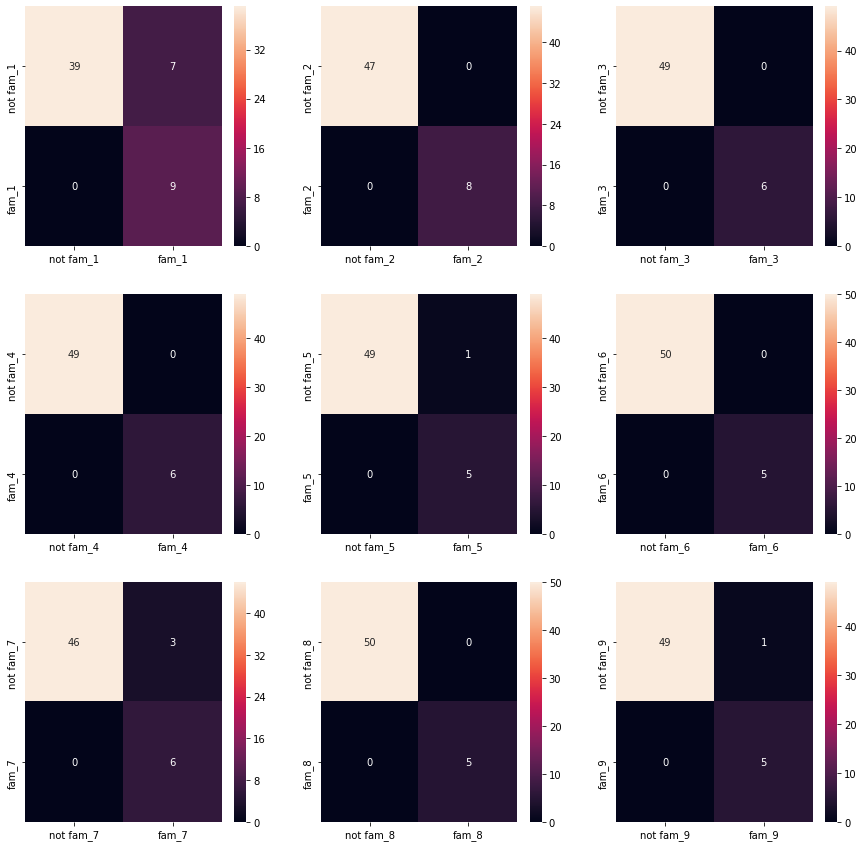

In [38]:
plt.figure(1, figsize=(15,15))
for i,f in enumerate(families):
    df_cm = pd.DataFrame([[tn[f], fp[f]],[ fn[f], tp[f]]], index = ["not " + f, f],
                      columns = ["not " + f, f])
    plt.subplot(330 + i + 1)
    sn.heatmap(df_cm, annot=True, fmt='g')